## Pumpkin Pricing

Load up required libraries and dataset. Convert the data to a dataframe containing a subset of the data: 

- Only get pumpkins priced by the bushel
- Convert the date to a month
- Calculate the price to be an average of high and low prices
- Convert the price to reflect the pricing by bushel quantity

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('../data/US-pumpkins.csv')

pumpkins.head()


,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [3]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

columns_to_select = ['Package', 'Variety', 'City Name', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.loc[:, columns_to_select]

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month

day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)


print('Day of Year', day_of_year)
new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


Day of Year 70      267
71      267
72      274
73      274
74      281
       ... 
1738    273
1739    273
1740    273
1741    273
1742    273
Name: Date, Length: 415, dtype: int64


/var/folders/3g/crglsgrx0b93gsg2cp9k_3km0000gn/T/ipykernel_51094/4288335600.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)


,Month,DayOfYear,Variety,City,Package,Low Price,High Price,Price
70,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364
71,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
72,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
73,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,17.0,17.0,15.454545
74,10,281,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364


A basic scatterplot reminds us that we only have month data from August through December. We probably need more data to be able to draw conclusions in a linear fashion.

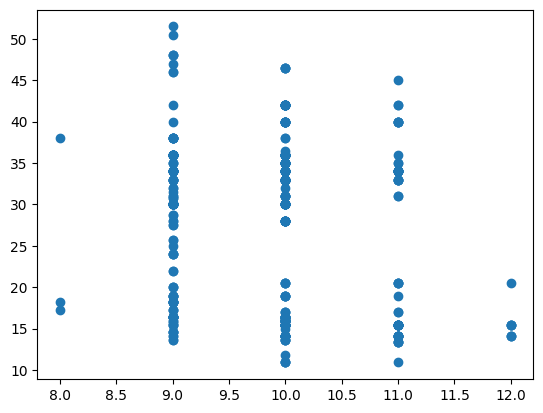

In [4]:
import matplotlib.pyplot as plt
plt.scatter('Month','Price',data=new_pumpkins)

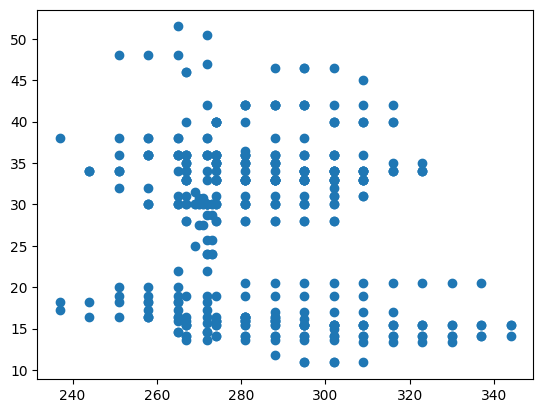

In [5]:

plt.scatter('DayOfYear','Price',data=new_pumpkins)

In [6]:
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

-0.1487829355407752
-0.16673322492745402


<Axes: xlabel='DayOfYear', ylabel='Price'>

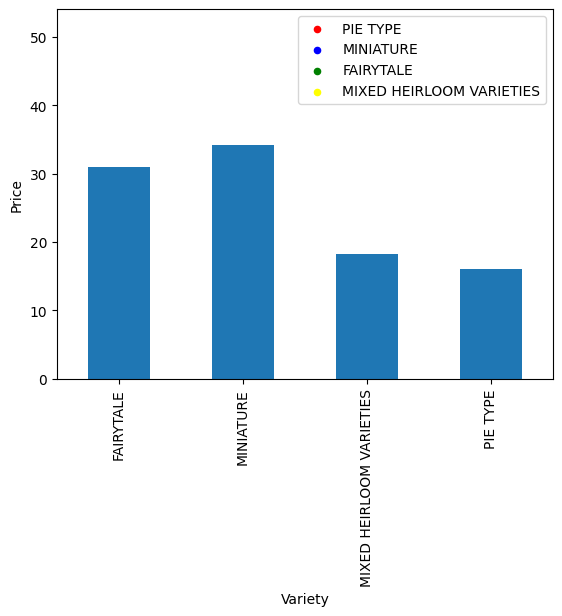

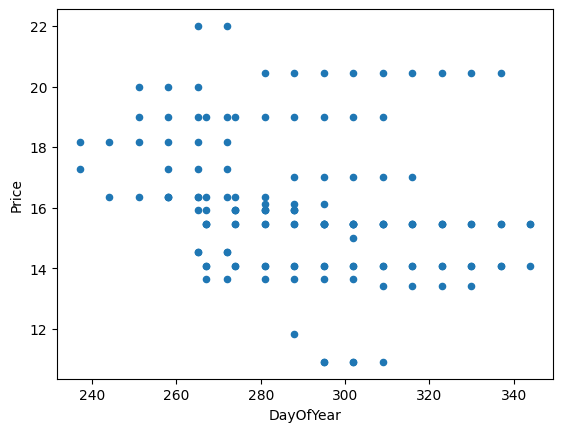

In [7]:
ax=None
colors = ['red','blue','green','yellow']
for i,var in enumerate(new_pumpkins['Variety'].unique()):
    df = new_pumpkins[new_pumpkins['Variety']==var]
    ax = df.plot.scatter('DayOfYear','Price',ax=ax,c=colors[i],label=var)

new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')
pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='PIE TYPE']
pie_pumpkins.plot.scatter('DayOfYear','Price')

In [8]:
print(pie_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

-0.2669192282197318


In [9]:
pie_pumpkins.dropna(inplace=True)



/var/folders/3g/crglsgrx0b93gsg2cp9k_3km0000gn/T/ipykernel_51094/4119199810.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pie_pumpkins.dropna(inplace=True)


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)
mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

Mean error: 2.77 (17.2%)


In [11]:
score = lin_reg.score(X_train,y_train)
print('Model determination: ', score)

Model determination:  0.04460606335028361


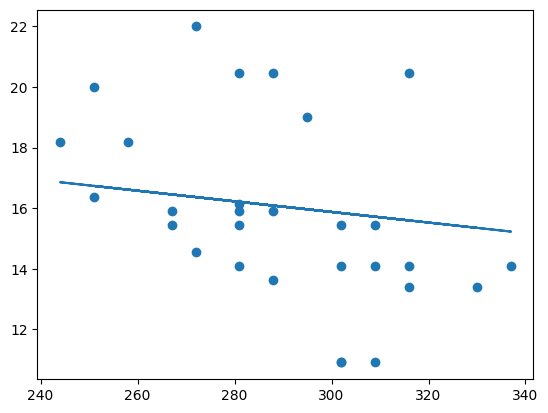

In [12]:

plt.scatter(X_test,y_test)
plt.plot(X_test,pred)


In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


Mean error: 2.73 (17.0%)
Model determination:  0.07639977655280139


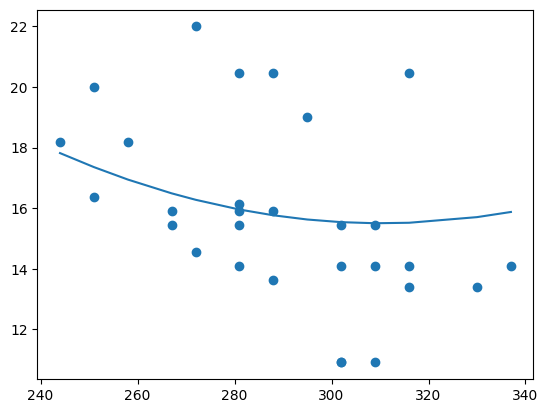

In [14]:

# setup and train the pipeline
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

# predict results for test data
pred = pipeline.predict(X_test)

# calculate MSE and determination
mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

# Plot the Results
plt.scatter(X_test, y_test)

plt.plot(sorted(X_test), pipeline.predict(sorted(X_test)))

In [15]:
# set up training data

X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))


y = new_pumpkins['Price']

# make train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# setup and train the pipeline
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

# predict results for test data
pred = pipeline.predict(X_test)
print("Pred: ", pred)
# calculate MSE and determination
mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)



Pred:  [46.5826416  16.80285645 18.36828613 15.22839355 16.70239258 16.70239258
 16.80285645 15.21508789 15.14648438 33.54382324 41.59667969 31.02282715
 28.38623047 34.94824219 41.59667969 13.36230469 16.0612793  16.93127441
 15.21508789 34.94824219 41.59667969 32.45288086 46.5826416  14.22143555
 16.89245605 16.23706055 34.94824219 33.54382324 16.0612793  37.07275391
 39.16552734 35.87316895 34.00793457 15.21508789 28.80065918 41.59667969
 35.83886719 16.89245605 13.8770752  33.54382324 46.5826416  13.86645508
 28.80065918 48.92565918 35.83886719 16.91638184 36.33618164 32.78918457
 31.02282715 18.28344727 28.38623047 15.21508789 15.14648438 37.07275391
 16.89245605 28.80065918 35.83886719 16.93127441 35.87316895 28.80065918
 34.94824219 14.03723145 36.33618164 16.93127441 16.93127441 34.94824219
 33.78881836 32.45288086 32.45288086 33.78881836 16.93127441 15.21508789
 36.33618164 41.59667969 16.93127441 33.54382324 15.21508789 36.33618164
 37.07275391 33.10925293 15.21594238 15.1470

/var/folders/3g/crglsgrx0b93gsg2cp9k_3km0000gn/T/ipykernel_51094/2050147999.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_varieties))


z :  [-0.0055643   1.26417623 -2.16538066]


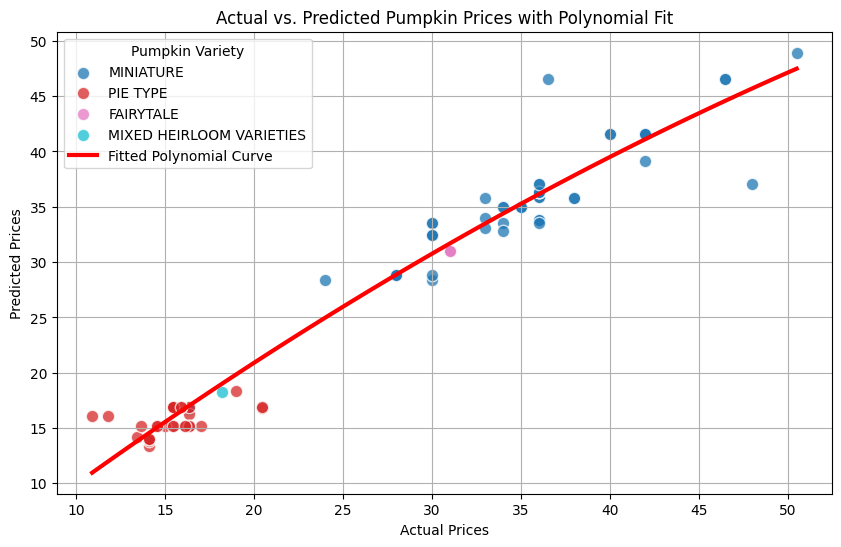

In [19]:
# Assuming `new_pumpkins['Variety']` contains the pumpkin types
varieties = new_pumpkins.loc[y_test.index, 'Variety']  # Get the pumpkin types corresponding to y_test
unique_varieties = varieties.unique()

# Create a colormap using Matplotlib (assign a different color to each variety)
colors = plt.cm.get_cmap('tab10', len(unique_varieties))

# Plot Actual vs. Predicted prices with different colors for each variety
plt.figure(figsize=(10,6))

for i, variety in enumerate(unique_varieties):
    mask = varieties == variety  # Filter the rows for this variety
    plt.scatter(y_test[mask], pred[mask], color=colors(i), label=variety, s=80, edgecolor='w', alpha=0.75)

# Fit a 2nd-degree polynomial (since we used PolynomialFeatures(2))
z = np.polyfit(y_test, pred, 2)  # Fit a 2nd degree polynomial
print('z : ',z)
p = np.poly1d(z)  # Create a polynomial object

# Generate points to plot the fitted curve
x_range = np.linspace(y_test.min(), y_test.max(), 100)
plt.plot(x_range, p(x_range), color='red', lw=3, label='Fitted Polynomial Curve')

plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Pumpkin Prices with Polynomial Fit')
plt.legend(title="Pumpkin Variety")
plt.grid(True)
plt.show()

